In [1]:
# netcdf/numpy/xray/stats
import xarray as xr

import sys
sys.path.append('../../')
import sosutils
from sostidy import SOSTidy
from gradients import LogLinear, CentralDifferencing, \
    LogPolynomial, LogPolynomialWithRoughness, Ri

from metpy.units import units
import metpy
import pint_xarray
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('svg')
import pytz

import pandas as pd
import datetime as dt

from urllib.error import URLError
import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Inputs

In [2]:
sos_download_dir='/data2/elilouis/sublimationofsnow/sosnoqc'
DATE_FORMAT_STR = '%Y%m%d'
# start_date = '20221201'
# end_date = dt.datetime.strftime(dt.date.today() - dt.timedelta(days=1), DATE_FORMAT_STR)
start_date = '20221130'
end_date = '20230509'
PLANAR_FIT = False




datelist = pd.date_range(
    dt.datetime.strptime(start_date, DATE_FORMAT_STR),
    dt.datetime.strptime(end_date, DATE_FORMAT_STR),
    freq='d'
).strftime(DATE_FORMAT_STR).tolist()

VARIABLE_NAMES = [
    # Sonic Anemometer Data for 4 towers
    'tc_1m_uw',     'spd_1m_uw',     'dir_1m_uw',     'u_1m_uw',   'v_1m_uw',   'w_1m_uw',   'u_u__1m_uw',    'v_v__1m_uw',    'w_w__1m_uw',    
        'u_w__1m_uw',    'v_w__1m_uw',  'u_tc__1m_uw',  'v_tc__1m_uw',   'u_h2o__1m_uw',  'v_h2o__1m_uw',   'w_tc__1m_uw',   'w_h2o__1m_uw',
    'tc_3m_uw',     'spd_3m_uw',     'dir_3m_uw',     'u_3m_uw',   'v_3m_uw',   'w_3m_uw',   'u_u__3m_uw',    'v_v__3m_uw',    'w_w__3m_uw',    
        'u_w__3m_uw',    'v_w__3m_uw',  'u_tc__3m_uw',  'v_tc__3m_uw',   'u_h2o__3m_uw',  'v_h2o__3m_uw',   'w_tc__3m_uw',   'w_h2o__3m_uw',
    'tc_10m_uw',    'spd_10m_uw',    'dir_10m_uw',    'u_10m_uw',  'v_10m_uw',  'w_10m_uw',  'u_u__10m_uw',   'v_v__10m_uw',   'w_w__10m_uw',   
        'u_w__10m_uw',   'v_w__10m_uw', 'u_tc__10m_uw', 'v_tc__10m_uw',  'u_h2o__10m_uw', 'v_h2o__10m_uw',  'w_tc__10m_uw',  'w_h2o__10m_uw',

    'tc_1m_ue',     'spd_1m_ue',     'dir_1m_ue',     'u_1m_ue',   'v_1m_ue',   'w_1m_ue',   'u_u__1m_ue',    'v_v__1m_ue',    'w_w__1m_ue',    
        'u_w__1m_ue',    'v_w__1m_ue',  'u_tc__1m_ue',  'v_tc__1m_ue',   'u_h2o__1m_ue',  'v_h2o__1m_ue',   'w_tc__1m_ue',   'w_h2o__1m_ue',
    'tc_3m_ue',     'spd_3m_ue',     'dir_3m_ue',     'u_3m_ue',   'v_3m_ue',   'w_3m_ue',   'u_u__3m_ue',    'v_v__3m_ue',    'w_w__3m_ue',    
        'u_w__3m_ue',    'v_w__3m_ue',  'u_tc__3m_ue',  'v_tc__3m_ue',   'u_h2o__3m_ue',  'v_h2o__3m_ue',   'w_tc__3m_ue',   'w_h2o__3m_ue',
    'tc_10m_ue',    'spd_10m_ue',    'dir_10m_ue',    'u_10m_ue',  'v_10m_ue',  'w_10m_ue',  'u_u__10m_ue',   'v_v__10m_ue',   'w_w__10m_ue',   
        'u_w__10m_ue',   'v_w__10m_ue', 'u_tc__10m_ue', 'v_tc__10m_ue',  'u_h2o__10m_ue', 'v_h2o__10m_ue',  'w_tc__10m_ue',  'w_h2o__10m_ue',

    'tc_1m_d',      'spd_1m_d',     'dir_1m_d',     'u_1m_d',   'v_1m_d',   'w_1m_d',   'u_u__1m_d',    'v_v__1m_d',    'w_w__1m_d',    
        'u_w__1m_d',    'v_w__1m_d',  'u_tc__1m_d',  'v_tc__1m_d',   'u_h2o__1m_d',  'v_h2o__1m_d',   'w_tc__1m_d',   'w_h2o__1m_d',
    'tc_3m_d',      'spd_3m_d',     'dir_3m_d',     'u_3m_d',   'v_3m_d',   'w_3m_d',   'u_u__3m_d',    'v_v__3m_d',    'w_w__3m_d',    
        'u_w__3m_d',    'v_w__3m_d',  'u_tc__3m_d',  'v_tc__3m_d',   'u_h2o__3m_d',  'v_h2o__3m_d',   'w_tc__3m_d',   'w_h2o__3m_d',
    'tc_10m_d',     'spd_10m_d',    'dir_10m_d',    'u_10m_d',  'v_10m_d',  'w_10m_d',  'u_u__10m_d',   'v_v__10m_d',   'w_w__10m_d',   
        'u_w__10m_d',   'v_w__10m_d', 'u_tc__10m_d', 'v_tc__10m_d',  'u_h2o__10m_d', 'v_h2o__10m_d',  'w_tc__10m_d',  'w_h2o__10m_d',

    'tc_2m_c',  'spd_2m_c',     'dir_2m_c',     'u_2m_c',   'v_2m_c',   'w_2m_c',   'u_u__2m_c',    'v_v__2m_c',    'w_w__2m_c',    
        'u_w__2m_c',    'v_w__2m_c',  'u_tc__2m_c',  'v_tc__2m_c',   'u_h2o__2m_c',  'v_h2o__2m_c',   'w_tc__2m_c',   'w_h2o__2m_c',
    'tc_3m_c',  'spd_3m_c',     'dir_3m_c',     'u_3m_c',   'v_3m_c',   'w_3m_c',   'u_u__3m_c',    'v_v__3m_c',    'w_w__3m_c',    
        'u_w__3m_c',    'v_w__3m_c',  'u_tc__3m_c',  'v_tc__3m_c',   'u_h2o__3m_c',  'v_h2o__3m_c',   'w_tc__3m_c',   'w_h2o__3m_c',
    'tc_5m_c',  'spd_5m_c',     'dir_5m_c',     'u_5m_c',   'v_5m_c',   'w_5m_c',   'u_u__5m_c',    'v_v__5m_c',    'w_w__5m_c',    
        'u_w__5m_c',    'v_w__5m_c',  'u_tc__5m_c',  'v_tc__5m_c',   'u_h2o__5m_c',  'v_h2o__5m_c',   'w_tc__5m_c',   'w_h2o__5m_c',
    'tc_10m_c', 'spd_10m_c',    'dir_10m_c',    'u_10m_c',  'v_10m_c',  'w_10m_c',  'u_u__10m_c',   'v_v__10m_c',   'w_w__10m_c',   
        'u_w__10m_c',   'v_w__10m_c', 'u_tc__10m_c', 'v_tc__10m_c',  'u_h2o__10m_c', 'v_h2o__10m_c',  'w_tc__10m_c',  'w_h2o__10m_c',
    'tc_15m_c', 'spd_15m_c',    'dir_15m_c',    'u_15m_c',  'v_15m_c',  'w_15m_c',  'u_u__15m_c',   'v_v__15m_c',   'w_w__15m_c',   
        'u_w__15m_c',   'v_w__15m_c', 'u_tc__15m_c', 'v_tc__15m_c',  'u_h2o__15m_c', 'v_h2o__15m_c',  'w_tc__15m_c',  'w_h2o__15m_c',
    'tc_20m_c', 'spd_20m_c',    'dir_20m_c',    'u_20m_c',  'v_20m_c',  'w_20m_c',  'u_u__20m_c',   'v_v__20m_c',   'w_w__20m_c',   
        'u_w__20m_c',   'v_w__20m_c', 'u_tc__20m_c', 'v_tc__20m_c',  'u_h2o__20m_c', 'v_h2o__20m_c',  'w_tc__20m_c',  'w_h2o__20m_c',

    
    # Temperature & Relative Humidity Array 
    'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
    'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

    'RH_2m_c', 'RH_3m_c', 'RH_4m_c', 'RH_5m_c', 'RH_6m_c', 'RH_7m_c', 'RH_8m_c', 'RH_9m_c', 'RH_10m_c',
    'RH_11m_c','RH_12m_c','RH_13m_c','RH_14m_c','RH_15m_c','RH_16m_c','RH_17m_c','RH_18m_c','RH_19m_c','RH_20m_c',

    # Pressure Sensors
    'P_20m_c',
    'P_10m_c', 'P_10m_d', 'P_10m_uw', 'P_10m_ue',

    # Blowing snow/FlowCapt Sensors
    'SF_avg_1m_ue', 'SF_avg_2m_ue',

    # Apogee sensors
    "Vtherm_c", "Vtherm_d", "Vtherm_ue", "Vtherm_uw", 
    "Vpile_c", "Vpile_d", "Vpile_ue", "Vpile_uw",
    "IDir_c", "IDir_d", "IDir_ue", "IDir_uw",

    # Snow-level temperature arrays (towers D and UW)
    'Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d', 'Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d',
    'Tsnow_0_4m_uw', 'Tsnow_0_5m_uw', 'Tsnow_0_6m_uw', 'Tsnow_0_7m_uw', 'Tsnow_0_8m_uw', 'Tsnow_0_9m_uw', 'Tsnow_1_0m_uw', 'Tsnow_1_1m_uw', 'Tsnow_1_2m_uw', 'Tsnow_1_3m_uw', 'Tsnow_1_4m_uw', 'Tsnow_1_5m_uw',
    
    # Downward Facing Longwave Radiometer (tower D) - for measuring snow surface temperature
    'Rpile_out_9m_d',
    'Tcase_out_9m_d',
    
    # Upward facing shortwave radiometer (tower D) - for measuring incoming solar radiation!
    'Rsw_in_9m_d',
]

# Download SoS data

In [3]:
datelist = pd.date_range(
    dt.datetime.strptime(start_date, DATE_FORMAT_STR),
    dt.datetime.strptime(end_date, DATE_FORMAT_STR),
    freq='d'
).strftime(DATE_FORMAT_STR).tolist()

In [4]:
# We make sure that we aren't accessing variables that don't exist in the datasets
# This is necessary because some daily NetCDF files don't have all the expected variables
# (for example because an instrument was down). In that case, we want to add that variable
# to the dataset, filled with nans, which sosutils.merge_datasets_with_different_variables
# handles for us
datasets = []
datasets_safe = []
for date in datelist:
    try:
        ds = xr.open_dataset(sosutils.download_sos_data_day(date, sos_download_dir, cache=True, planar_fit=PLANAR_FIT))
    # Some dates are missing
    except URLError:
        print(f"failed on {date}, skipping")
    ds_new = ds[set(ds.data_vars).intersection(VARIABLE_NAMES)]
    datasets.append(ds_new)
    datasets_safe.append(ds_new)
sos_ds = sosutils.merge_datasets_with_different_variables(datasets, dim='time')

Caching...skipping download for 20221130
Caching...skipping download for 20221201
Caching...skipping download for 20221202
Caching...skipping download for 20221203
Caching...skipping download for 20221204
Caching...skipping download for 20221205
Caching...skipping download for 20221206
Caching...skipping download for 20221207
Caching...skipping download for 20221208
Caching...skipping download for 20221209
Caching...skipping download for 20221210
Caching...skipping download for 20221211
Caching...skipping download for 20221212
Caching...skipping download for 20221213
Caching...skipping download for 20221214
Caching...skipping download for 20221215
Caching...skipping download for 20221216
Caching...skipping download for 20221217
Caching...skipping download for 20221218
Caching...skipping download for 20221219
Caching...skipping download for 20221220
Caching...skipping download for 20221221
Caching...skipping download for 20221222
Caching...skipping download for 20221223
Caching...skippi

# Fill in missing timestamps (with nans)

Note that this occurs if there is missing data at the beginning or end of day - those timestamps will be left out of the dataset. 

In [5]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

def date_range(start_date, end_date, increment, period):
    result = []
    nxt = start_date
    delta = relativedelta(**{period:increment})
    while nxt <= end_date:
        result.append(nxt)
        nxt += delta

    return result


In [6]:
dt_list = date_range(pd.to_datetime(sos_ds.time.values[0]), pd.to_datetime(sos_ds.time.values[-1]), 5, 'minutes')

In [7]:
sos_ds = sos_ds.drop_duplicates(dim='time').reindex(time=dt_list)

# Calculate surface temperatures

Add new calculated variables to the dataset

From EOL (https://www.eol.ucar.edu/content/calculation-long-wave-radiation)
$$
R_{lw} = R_{pile} + SB * T_{case}^4
$$
And the steven-boltzman law
$$
T_{surface} = \Big( \frac {R_{lw}}{ \epsilon \sigma } \Big)^\frac{1}{4}
$$

In [8]:
SB = 5.67e-08 # steven boltzman constant, W/m^2/degK^4
SNOW_EMMISIVITY = 0.98
sos_ds['Tsurf_rad_d'] = ((sos_ds['Rpile_out_9m_d'] + SB * (sos_ds['Tcase_out_9m_d']+273.15)**4)/(SNOW_EMMISIVITY*SB))**(1/4) - 273.15

# Surface Temperature
# calculate from apogees
sos_ds['Tsurf_c'] = (['time'],  sosutils.apogee2temp(sos_ds, 'c').values)
sos_ds['Tsurf_d'] = (['time'],  sosutils.apogee2temp(sos_ds, 'd').values)
sos_ds['Tsurf_ue'] = (['time'],  sosutils.apogee2temp(sos_ds, 'ue').values)
sos_ds['Tsurf_uw'] = (['time'],  sosutils.apogee2temp(sos_ds, 'uw').values)

/home/elilouis/mambaforge/envs/arm/lib/python3.11/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/elilouis/mambaforge/envs/arm/lib/python3.11/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


# Calculate potential and virtual potential temperatures in the air

Note that we use the `metpy` library here, which assigns units to each dataarray, in a "object oriented" way using the `pint` library. You don't really have to worry about this, only to know that it can make working with the data more confusing. Know that at the end of the following cell, when we assign the new variables to the dataset, we remove any remnants of the `pint` library, and we assign an attribute `units` to each new variable so that they somewhat match the variables provided in the original dataset.

In [9]:
# Potential Temperature
# iterate over pressure measurements
for i in range(2,21):
    absolute_temperature = sos_ds[f'T_{i}m_c'] * units.celsius
    relative_humidity = sos_ds[f'RH_{i}m_c']
    absolute_pressure = sos_ds['P_10m_c'] * units.millibar
    height_relative_to_10m_pressure_sensor = i*units.m - (10*units.m)

    height_adj_pressure = metpy.calc.add_height_to_pressure(
        absolute_pressure, 
        height_relative_to_10m_pressure_sensor
    )
    potential_temperature = metpy.calc.potential_temperature(    
            height_adj_pressure,
            absolute_temperature
    ).pint.to(units.celsius)
    mixing_ratio = xr.DataArray(relative_humidity/100) * metpy.calc.saturation_mixing_ratio(
        height_adj_pressure,
        absolute_temperature
    )
    air_density = metpy.calc.density(height_adj_pressure, absolute_temperature, mixing_ratio)
    virtual_potential_temperature = metpy.calc.virtual_temperature(
        potential_temperature,
        mixing_ratio,
    )

    virtual_temperature = metpy.calc.virtual_temperature(
        absolute_temperature,
        mixing_ratio,
    )
   
    sos_ds[f'Tpot_{i}m_c'] = (['time'], potential_temperature.pint.magnitude)
    sos_ds[f'Tpot_{i}m_c'] = sos_ds[f'Tpot_{i}m_c'].assign_attrs(units = str(potential_temperature.pint.units))

    sos_ds[f'Tvirtual_{i}m_c'] = (['time'], virtual_temperature.pint.magnitude)
    sos_ds[f'Tvirtual_{i}m_c'] = sos_ds[f'Tvirtual_{i}m_c'].assign_attrs(units = str(virtual_temperature.pint.units))

    sos_ds[f'Tpotvirtual_{i}m_c'] = (['time'], virtual_potential_temperature.pint.magnitude)
    sos_ds[f'Tpotvirtual_{i}m_c'] = sos_ds[f'Tpotvirtual_{i}m_c'].assign_attrs(units = str(virtual_potential_temperature.pint.units))

    sos_ds[f'airdensity_{i}m_c'] = (['time'], air_density.pint.magnitude)
    sos_ds[f'airdensity_{i}m_c'] = sos_ds[f'airdensity_{i}m_c'].assign_attrs(units = str(air_density.pint.units))

    sos_ds[f'mixingratio_{i}m_c'] = (['time'], mixing_ratio.pint.magnitude)
    sos_ds[f'mixingratio_{i}m_c'] = sos_ds[f'mixingratio_{i}m_c'].assign_attrs(units = str(mixing_ratio.pint.units))


# Calculate virtual potential temperatures at the snow surface

These are pretty much the same calculations as above, except we use the snow surface temperature from the longwave radiometer instead of air temperature.

Also, we assume that relative humidity at the snow surface is 100%

In [10]:
height_relative_to_10m_pressure_sensor = - (10*units.m)
absolute_temperature = sos_ds['Tsurf_rad_d']*units.celsius
absolute_pressure = sos_ds['P_10m_c'] * units.millibar

relative_humidity = 100

height_adj_pressure = metpy.calc.add_height_to_pressure(
    absolute_pressure, 
    height_relative_to_10m_pressure_sensor
)

potential_temperature = metpy.calc.potential_temperature(    
    height_adj_pressure,
    absolute_temperature
).pint.to(units.celsius)

mixing_ratio = xr.DataArray(relative_humidity/100) * metpy.calc.saturation_mixing_ratio(
        height_adj_pressure,
        absolute_temperature
    )
air_density = metpy.calc.density(height_adj_pressure, absolute_temperature, mixing_ratio)

virtual_potential_temperature = metpy.calc.virtual_temperature(
    potential_temperature,
    mixing_ratio,
)

virtual_temperature = metpy.calc.virtual_temperature(
    absolute_temperature,
    mixing_ratio,
)

sos_ds[f'Tsurfvirtual_rad_c'] = (['time'], virtual_temperature.pint.magnitude)
sos_ds[f'Tsurfvirtual_rad_c'] = sos_ds[f'Tsurfvirtual_rad_c'].assign_attrs(units = str(virtual_temperature.pint.units))

sos_ds[f'Tsurfpotvirtual_rad_c'] = (['time'], virtual_potential_temperature.pint.magnitude)
sos_ds[f'Tsurfpotvirtual_rad_c'] = sos_ds[f'Tsurfpotvirtual_rad_c'].assign_attrs(units = str(virtual_potential_temperature.pint.units))

sos_ds[f'Tsurfairdensity_rad_c'] = (['time'], air_density.pint.magnitude)
sos_ds[f'Tsurfairdensity_rad_c'] = sos_ds[f'Tsurfairdensity_rad_c'].assign_attrs(units = str(air_density.pint.units))

sos_ds[f'Tsurfmixingratio_rad_c'] = (['time'], mixing_ratio.pint.magnitude)
sos_ds[f'Tsurfmixingratio_rad_c'] = sos_ds[f'Tsurfmixingratio_rad_c'].assign_attrs(units = str(mixing_ratio.pint.units))

sos_ds[f'Tsurfpot_rad_c'] = (['time'], potential_temperature.pint.magnitude)
sos_ds[f'Tsurfpot_rad_c'] = sos_ds[f'Tsurfpot_rad_c'].assign_attrs(units = str(potential_temperature.pint.units))

# Calculate turbulent kinetic energy

In [11]:
sos_ds['tke_2m_c'] = 0.5*(sos_ds['u_u__2m_c'] + sos_ds['v_v__2m_c'] + sos_ds['w_w__2m_c'])
sos_ds['tke_3m_c'] = 0.5*(sos_ds['u_u__3m_c'] + sos_ds['v_v__3m_c'] + sos_ds['w_w__3m_c'])
sos_ds['tke_5m_c'] = 0.5*(sos_ds['u_u__5m_c'] + sos_ds['v_v__5m_c'] + sos_ds['w_w__5m_c'])
sos_ds['tke_10m_c'] = 0.5*(sos_ds['u_u__10m_c'] + sos_ds['v_v__10m_c'] + sos_ds['w_w__10m_c'])
sos_ds['tke_15m_c'] = 0.5*(sos_ds['u_u__15m_c'] + sos_ds['v_v__15m_c'] + sos_ds['w_w__15m_c'])
sos_ds['tke_20m_c'] = 0.5*(sos_ds['u_u__20m_c'] + sos_ds['v_v__20m_c'] + sos_ds['w_w__20m_c'])

sos_ds['tke_1m_uw'] = 0.5*(sos_ds['u_u__1m_uw'] + sos_ds['v_v__1m_uw'] + sos_ds['w_w__1m_uw'])
sos_ds['tke_3m_uw'] = 0.5*(sos_ds['u_u__3m_uw'] + sos_ds['v_v__3m_uw'] + sos_ds['w_w__3m_uw'])
sos_ds['tke_10m_uw'] = 0.5*(sos_ds['u_u__10m_uw'] + sos_ds['v_v__10m_uw'] + sos_ds['w_w__10m_uw'])

sos_ds['tke_1m_ue'] = 0.5*(sos_ds['u_u__1m_ue'] + sos_ds['v_v__1m_ue'] + sos_ds['w_w__1m_ue'])
sos_ds['tke_3m_ue'] = 0.5*(sos_ds['u_u__3m_ue'] + sos_ds['v_v__3m_ue'] + sos_ds['w_w__3m_ue'])
sos_ds['tke_10m_ue'] = 0.5*(sos_ds['u_u__10m_ue'] + sos_ds['v_v__10m_ue'] + sos_ds['w_w__10m_ue'])

sos_ds['tke_1m_d'] = 0.5*(sos_ds['u_u__1m_d'] + sos_ds['v_v__1m_d'] + sos_ds['w_w__1m_d'])
sos_ds['tke_3m_d'] = 0.5*(sos_ds['u_u__3m_d'] + sos_ds['v_v__3m_d'] + sos_ds['w_w__3m_d'])
sos_ds['tke_10m_d'] = 0.5*(sos_ds['u_u__10m_d'] + sos_ds['v_v__10m_d'] + sos_ds['w_w__10m_d'])

# Calculate gradients and Ri

By the methodology of Sun et al., 2011, we cannot calculate gradients at the lowest and highest levels because each gradient calculation requires 3 measurements - the measurement below, at, and above the measurement height.

In [12]:
sos_ds['wind_gradient_2m_c'] = (['time'], LogPolynomial.calculate_wind_gradient_for_height(sos_ds, 2, 'c').values)
sos_ds['wind_gradient_3m_c'] = (['time'], LogPolynomial.calculate_wind_gradient_for_height(sos_ds, 3, 'c').values)
sos_ds['wind_gradient_5m_c'] = (['time'], LogPolynomial.calculate_wind_gradient_for_height(sos_ds, 5, 'c').values)
sos_ds['wind_gradient_10m_c'] = (['time'], LogPolynomial.calculate_wind_gradient_for_height(sos_ds, 10, 'c').values)
sos_ds['wind_gradient_15m_c'] = (['time'], LogPolynomial.calculate_wind_gradient_for_height(sos_ds, 15, 'c').values)
sos_ds['wind_gradient_20m_c'] = (['time'], LogPolynomial.calculate_wind_gradient_for_height(sos_ds, 20, 'c').values)

sos_ds['temp_gradient_2m_c'] = (['time'], 
    LogPolynomialWithRoughness.calculate_temperature_gradient_for_height(
        sos_ds, 2
    ).values
)
sos_ds['temp_gradient_3m_c'] = (['time'], 
    LogPolynomialWithRoughness.calculate_temperature_gradient_for_height(
        sos_ds, 3
    ).values
)
sos_ds['temp_gradient_5m_c'] = (['time'], 
    LogPolynomialWithRoughness.calculate_temperature_gradient_for_height(
        sos_ds, 5
    ).values
)
sos_ds['temp_gradient_10m_c'] = (['time'], 
    LogPolynomialWithRoughness.calculate_temperature_gradient_for_height(
        sos_ds, 10)
    .values
)
sos_ds['temp_gradient_15m_c'] = (['time'], 
    LogPolynomialWithRoughness.calculate_temperature_gradient_for_height(
        sos_ds, 15
    ).values
)
sos_ds['temp_gradient_20m_c'] = (['time'], 
    LogPolynomialWithRoughness.calculate_temperature_gradient_for_height(
        sos_ds, 20
    ).values
)

sos_ds['Ri_2m_c'] = (['time'], Ri.calculate_richardson_number(sos_ds, 2, 'c'))
sos_ds['Ri_3m_c'] = (['time'], Ri.calculate_richardson_number(sos_ds, 3, 'c'))
sos_ds['Ri_5m_c'] = (['time'], Ri.calculate_richardson_number(sos_ds, 5, 'c'))
sos_ds['Ri_10m_c'] = (['time'], Ri.calculate_richardson_number(sos_ds, 10, 'c'))
sos_ds['Ri_15m_c'] = (['time'], Ri.calculate_richardson_number(sos_ds, 15, 'c'))
sos_ds['Ri_20m_c'] = (['time'], Ri.calculate_richardson_number(sos_ds, 20, 'c'))

sos_ds['RiB_2m_c'] = (['time'], Ri.calculate_richardson_number_bulk(sos_ds, 2, 'c'))
sos_ds['RiB_3m_c'] = (['time'], Ri.calculate_richardson_number_bulk(sos_ds, 3, 'c'))
sos_ds['RiB_5m_c'] = (['time'], Ri.calculate_richardson_number_bulk(sos_ds, 5, 'c'))
sos_ds['RiB_10m_c'] = (['time'], Ri.calculate_richardson_number_bulk(sos_ds, 10, 'c'))
sos_ds['RiB_15m_c'] = (['time'], Ri.calculate_richardson_number_bulk(sos_ds, 15, 'c'))
sos_ds['RiB_20m_c'] = (['time'], Ri.calculate_richardson_number_bulk(sos_ds, 20, 'c'))

# Calculate Obukhov length

$$ L = \frac{-\overline{\theta_v} u_*^3}{g k \overline{\theta_v^`w^`}} $$

But, we don't really need to consider pressure changes with height here, i.e. we don't need to use potential temperature. So we can use an alternate version of the equation

$$ L = \frac{-\overline{T_v} u_*^3}{g k \overline{T_v^`w^`}} $$

In [14]:
von_karman_constant = 0.4

# iterate over pressure measurements
for i in [2,3,5,10,15,20]:
    absolute_temperature = sos_ds[f'T_{i}m_c'] * units.celsius
    absolute_pressure = sos_ds['P_10m_c'] * units.millibar
    height_relative_to_10m_pressure_sensor = i*units.m - (10*units.m)

    height_adj_pressure = metpy.calc.add_height_to_pressure(
        absolute_pressure, 
        height_relative_to_10m_pressure_sensor
    )

    shear_velocity = np.sqrt(np.sqrt(sos_ds[f'u_w__{i}m_c']**2 + sos_ds[f'v_w__{i}m_c']**2))

    L = - ( 
        (273.15 + sos_ds[f'Tvirtual_{i}m_c']) * shear_velocity**3 
    ) / (
        metpy.constants.g.magnitude * von_karman_constant * sos_ds[f'w_tc__{i}m_c']
    )
    
    sos_ds[f'u*_{i}m_c'] = shear_velocity
    sos_ds[f'L_{i}m_c'] = L

(-10.0, 10.0)

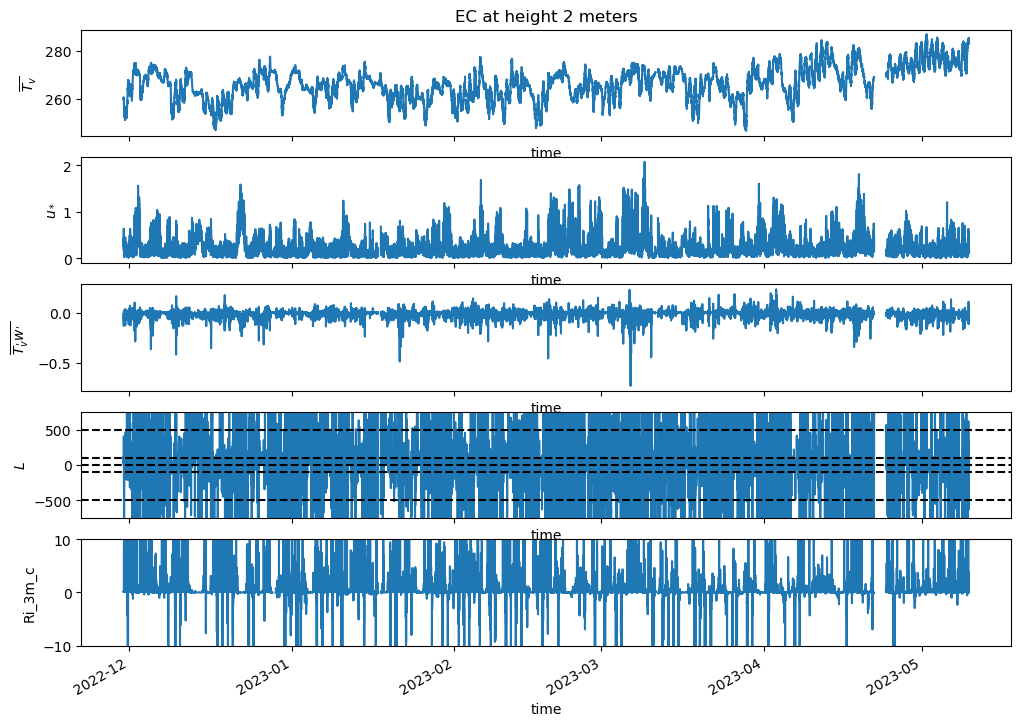

In [15]:
i = 2
fig, axes = plt.subplots(5, 1, figsize=(12,8), sharex=True)

(sos_ds[f'Tpotvirtual_{i}m_c']+273.15)

(sos_ds[f'Tvirtual_{i}m_c'] + 273.15).plot(ax = axes[0])
axes[0].set_ylabel(r'$\overline{T_v}$')

sos_ds[f'u*_{i}m_c'].plot(ax = axes[1])
axes[1].set_ylabel(r'$u_*$')

sos_ds[f'w_tc__{i}m_c'].plot(ax = axes[2])
axes[2].set_ylabel(r'$\overline{T_v^, w^,}$')

sos_ds[f'L_{i}m_c'].plot(ax = axes[3])
axes[3].axhline(-500, color='k', linestyle='--')
axes[3].axhline(-100, color='k', linestyle='--')
axes[3].axhline(0, color='k', linestyle='--')
axes[3].axhline(100, color='k', linestyle='--')
axes[3].axhline(500, color='k', linestyle='--')
axes[3].set_ylim(-750,750)
axes[3].set_ylabel(r'$L$')

axes[0].set_title(f"EC at height {i} meters")

sos_ds[f'Ri_3m_c'].plot(ax = axes[4])
axes[4].set_ylim(-10,10)

# Get Tidy Dataset

In [16]:
tidy_df = SOSTidy.get_tidy_dataset(sos_ds, list(sos_ds.data_vars))

In [ ]:
tidy_df = sosutils.modify_df_timezone(tidy_df, pytz.UTC, pytz.timezone('US/Mountain'))

Which variables did not get a "measurement" name assigned?

In [25]:
variables_with_no_measurement = tidy_df[tidy_df.measurement.apply(lambda x: x is None)].variable.unique()
variables_with_no_measurement

array(['Rpile_out_9m_d', 'Tcase_out_9m_d'], dtype=object)

# Calculate 30 Minute averages

In [26]:
SNOW_DEPTH = 0.9
PRESSURE_HEIGHT = 10
stab_titles, stab_methods, stab_dict = sosutils.get_turbpy_schemes()

In [27]:
tidy_df_30Min = pd.DataFrame(
    tidy_df.set_index('time').groupby(
        ['measurement', 'variable', 'height',  'tower']
    )['value'].resample('30Min').mean()
).reset_index()

# Save dataset

In [ ]:
if PLANAR_FIT:
    tidy_df_30Min.to_parquet(f'tidy_df_30Min_{start_date}_{end_date}_planar_fit.parquet', index=False)
else:
    tidy_df_30Min.to_parquet(f'tidy_df_30Min_{start_date}_{end_date}_noplanar_fit.parquet', index=False)

# Load disdrometer data and calculate "days since precip"

In [ ]:
import act

In [ ]:
files = act.discovery.download_data(
    os.getenv("ARM_USERNAME"),
    os.getenv("ARM_TOKEN"),
    'gucldM1.b1',
    start_date,
    end_date,
    output='/data2/elilouis/sublimationofsnow/gucldM1.b1'
)

In [ ]:
disdro_ds = xr.open_mfdataset(files)
disdro_df = disdro_ds.to_dataframe().reset_index()

In [ ]:
disdro_daily_max_precip_date_df = disdro_df.set_index(
    "time"
)[['precip_rate']].resample(
    "1440Min"
).max().reset_index()

disdro_daily_mean_precip_date_df = disdro_df.set_index(
    "time"
)[['precip_rate']].resample(
    "1440Min"
).max().reset_index()

s = disdro_daily_max_precip_date_df.groupby(disdro_daily_max_precip_date_df['precip_rate'].ne(0).cumsum())['time'].transform('first')
disdro_daily_max_precip_date_df['days_since_precip'] = (disdro_daily_max_precip_date_df['time'] - s).dt.days

In [ ]:
daily_mean_precip_df = disdro_df.groupby("time")['precip_rate'].max()

daily_mean_precip_df = pd.DataFrame(daily_mean_precip_df.resample("1440Min").mean()*24/10) # resample to one day in cm/hr SWE

In [ ]:
disdro_daily_max_precip_date_df['daily_precip (cm)'] =  daily_mean_precip_df['precip_rate'].values

In [ ]:
disdro_daily_max_precip_date_df

## Cache Downloaded Disdrometer data

In [ ]:
disdro_daily_max_precip_date_df.to_csv("disdro_daily_max_precip_date_df.csv")